# Introduction

Goals:

* Identify IMGT residue positions that make contact with the TCR
  * See what loops those correspond to on the TCR side of things

In [1]:
import glob
import os
import itertools
from collections import OrderedDict, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from python_pdb.parsers import parse_pdb_to_pandas

from tcr_pmhc_structure_tools.imgt_numbering import assign_cdr_number

In [2]:
STCRDAB_PATH = '../data/raw/stcrdab'

In [3]:
stcrdab_summary = pd.read_csv(os.path.join(STCRDAB_PATH, 'db_summary.dat'), delimiter='\t')

selected_stcrdab = stcrdab_summary.copy()

# Resolution better than 3.50 Å
selected_stcrdab['resolution'] = pd.to_numeric(selected_stcrdab['resolution'], errors='coerce')
selected_stcrdab = selected_stcrdab.query("resolution <= 3.50")

# alpha-beta TCRs
selected_stcrdab = selected_stcrdab.query("TCRtype == 'abTCR'")

# MHC class I
selected_stcrdab = selected_stcrdab.query("mhc_type == 'MH1'")

# peptide antigen
selected_stcrdab = selected_stcrdab.query("antigen_type == 'peptide'")

# General clean: drop columns that don't contain anything useful
selected_stcrdab = selected_stcrdab.loc[:, selected_stcrdab.nunique() > 1]
selected_stcrdab = selected_stcrdab.dropna(axis=1, how='all')

# Reset Index
selected_stcrdab = selected_stcrdab.reset_index(drop=True)

selected_stcrdab

,pdb,Bchain,Achain,antigen_chain,antigen_name,mhc_chain1,mhc_chain2,docking_angle,beta_subgroup,alpha_subgroup,...,alpha_organism,antigen_organism,mhc_chain1_organism,mhc_chain2_organism,authors,resolution,method,r_free,r_factor,engineered
0,8gom,E,D,C,spike protein s2,A,B,39.649,NaN,NaN,...,homo sapiens,severe acute respiratory syndrome coronavirus2,homo sapiens,homo sapiens,"Wu, D., Mariuzza, R.A.",2.783,X-RAY DIFFRACTION,0.248,0.195,True
1,8gon,E,D,C,spike protein s2,A,B,38.984,NaN,NaN,...,homo sapiens,severe acute respiratory syndrome coronavirus2,homo sapiens,homo sapiens,"Wu, D., Mariuzza, R.A.",2.601,X-RAY DIFFRACTION,0.253,0.198,True
2,7q99,E,D,C,asn-leu-ser-ala-leu-gly-ile-phe-ser-thr,A,B,46.371,TRBV30,TRAV12,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Sewell, A.K., Wall, A., Fulle...",2.550,X-RAY DIFFRACTION,0.272,0.218,True
3,7q9a,E,D,C,leu-leu-leu-gly-ile-gly-ile-leu-val-leu,A,B,48.391,TRBV30,TRAV12,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Sewell, A.K., Wall, A., Fulle...",2.100,X-RAY DIFFRACTION,0.243,0.205,True
4,2ak4,E,D,C,ebv peptide lpeplpqgqltay,A,B,71.108,TRBV6,TRAV19,...,homo sapiens,NaN,homo sapiens,homo sapiens,"Tynan, F.E., Burrows, S.R., Buckle, A.M., Clem...",2.500,X-RAY DIFFRACTION,0.278,0.246,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,6q3s,E,D,C,ser-leu-leu-met-trp-ile-thr-gln-val,A,B,67.059,TRBV6,TRAV21,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Meijers, R., Anjanappa, R., Springer, S., Garc...",2.500,X-RAY DIFFRACTION,0.273,0.229,True
298,5men,E,D,C,ile-leu-ala-lys-phe-leu-his-trp-leu,A,B,40.823,TRBV6,TRAV22,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Lloyd, A., Crowther, M., Cole...",2.810,X-RAY DIFFRACTION,0.272,0.189,True
299,1ao7,E,D,C,tax peptide,A,B,34.827,TRBV6,TRAV12,...,homo sapiens,human t-lymphotropic virus 1,homo sapiens,homo sapiens,"Garboczi, D.N., Ghosh, P., Utz, U., Fan, Q.R.,...",2.600,X-RAY DIFFRACTION,0.320,0.245,True
300,4jff,E,D,C,melanoma motif,A,B,42.977,TRBV30,TRAV12,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Cole, D.K., Madura, F., Sewel...",2.430,X-RAY DIFFRACTION,0.263,0.210,True


In [4]:
CUTOFF_DISTANCE = 5

contacts = []

for _, row in selected_stcrdab.iterrows():
    path = os.path.join(STCRDAB_PATH, 'imgt', f'{row.pdb}.pdb')

    with open(path, 'r') as fh:
        df = parse_pdb_to_pandas(fh.read())

    chain_annotations = {}
    chain_annotations[row.Achain] = 'alpha_chain'
    chain_annotations[row.Bchain] = 'beta_chain'
    chain_annotations[row.antigen_chain] = 'antigen_chain'
    chain_annotations[row.mhc_chain1] = 'mhc_chain'

    df['chain_type'] = df['chain_id'].map(lambda id_: chain_annotations[id_] if id_ in chain_annotations else None)
    df['cdr'] = df['residue_seq_id'].map(assign_cdr_number)

    mhc_interface_df = df.query("chain_type == 'mhc_chain' and residue_seq_id < 1090")
    tcr_cdrs_df = df.query("(chain_type == 'alpha_chain' or chain_type == 'beta_chain') and cdr.notnull()") 

    interface = tcr_cdrs_df.merge(mhc_interface_df, how='cross', suffixes=('_tcr', '_mhc'))

    interface['distance'] = np.sqrt(np.square(interface['pos_x_tcr'] - interface['pos_x_mhc'])
                                    + np.square(interface['pos_y_tcr'] - interface['pos_y_mhc'])
                                    + np.square(interface['pos_z_tcr'] - interface['pos_z_mhc']))

    c = interface.query('distance < @CUTOFF_DISTANCE').copy()
    c['path'] = path

    contacts.append(c)

contacts = pd.concat(contacts)
contacts

,record_type_tcr,atom_number_tcr,atom_name_tcr,alt_loc_tcr,residue_name_tcr,chain_id_tcr,residue_seq_id_tcr,residue_insert_code_tcr,pos_x_tcr,pos_y_tcr,...,pos_y_mhc,pos_z_mhc,occupancy_mhc,b_factor_mhc,element_mhc,charge_mhc,chain_type_mhc,cdr_mhc,distance,path
69473,ATOM,472,C,None,ASN,E,57,None,12.312,-60.161,...,-60.159,5.554,1.0,32.16,C,None,mhc_chain,NaN,4.705904,../data/raw/stcrdab/imgt/8gom.pdb
69474,ATOM,472,C,None,ASN,E,57,None,12.312,-60.161,...,-61.205,4.260,1.0,35.56,C,None,mhc_chain,NaN,4.333638,../data/raw/stcrdab/imgt/8gom.pdb
70937,ATOM,473,O,None,ASN,E,57,None,11.507,-60.966,...,-60.651,5.610,1.0,36.60,C,None,mhc_chain,NaN,4.541180,../data/raw/stcrdab/imgt/8gom.pdb
70938,ATOM,473,O,None,ASN,E,57,None,11.507,-60.966,...,-60.159,5.554,1.0,32.16,C,None,mhc_chain,NaN,4.370555,../data/raw/stcrdab/imgt/8gom.pdb
70939,ATOM,473,O,None,ASN,E,57,None,11.507,-60.966,...,-61.205,4.260,1.0,35.56,C,None,mhc_chain,NaN,3.461141,../data/raw/stcrdab/imgt/8gom.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523545,ATOM,10089,CD,None,GLN,N,114,None,-56.010,75.392,...,78.582,-4.548,1.0,63.82,O,None,mhc_chain,2.0,4.780427,../data/raw/stcrdab/imgt/3dxa.pdb
525009,ATOM,10090,OE1,None,GLN,N,114,None,-56.609,76.453,...,79.185,-4.987,1.0,63.97,C,None,mhc_chain,2.0,4.497415,../data/raw/stcrdab/imgt/3dxa.pdb
525010,ATOM,10090,OE1,None,GLN,N,114,None,-56.609,76.453,...,78.582,-4.548,1.0,63.82,O,None,mhc_chain,2.0,3.844840,../data/raw/stcrdab/imgt/3dxa.pdb
525011,ATOM,10090,OE1,None,GLN,N,114,None,-56.609,76.453,...,79.567,-4.216,1.0,64.14,N,None,mhc_chain,2.0,4.376160,../data/raw/stcrdab/imgt/3dxa.pdb


In [5]:
contacts['pdb_id'] = contacts['path'].map(lambda path: path.split('/')[-1].split('.')[0])

In [6]:
contacts['resi_mhc'] = contacts['residue_seq_id_mhc'].apply(str) + contacts['residue_insert_code_mhc'].fillna('')
contacts['resi_tcr'] = contacts['residue_seq_id_tcr'].apply(str) + contacts['residue_insert_code_tcr'].fillna('')

In [7]:
contacts['cdr_name'] = 'CDR' \
    + contacts['cdr_tcr'].apply(int).apply(str) \
    + contacts['chain_type_tcr'].map(lambda chain_type: chain_type.split('_')[0])

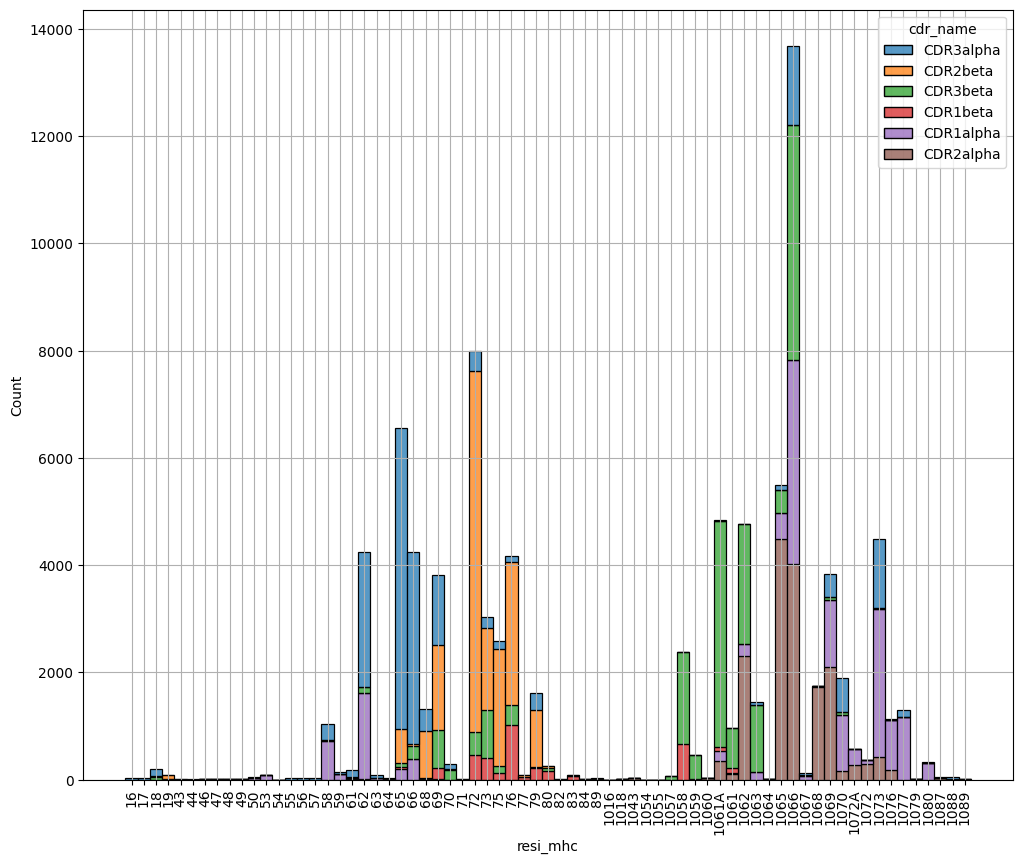

In [8]:
plt.figure(figsize=(12, 10))

sns.histplot(contacts.sort_values('residue_seq_id_mhc'), x='resi_mhc', hue='cdr_name', multiple='stack')
plt.xticks(rotation=90)
plt.grid()
print()

In [9]:
mhc_labels = contacts[['residue_seq_id_mhc', 'residue_insert_code_mhc', 'resi_mhc']].fillna('').sort_values(['residue_seq_id_mhc', 'residue_insert_code_mhc'])['resi_mhc'].unique().tolist()
tcr_labels = contacts[['residue_seq_id_tcr', 'residue_insert_code_tcr', 'resi_tcr']].fillna('').sort_values(['residue_seq_id_tcr', 'residue_insert_code_tcr'])['resi_tcr'].unique().tolist()

contacts['resi_mhc'] = pd.Categorical(contacts['resi_mhc'], mhc_labels)
contacts['resi_tcr'] = pd.Categorical(contacts['resi_tcr'], tcr_labels)

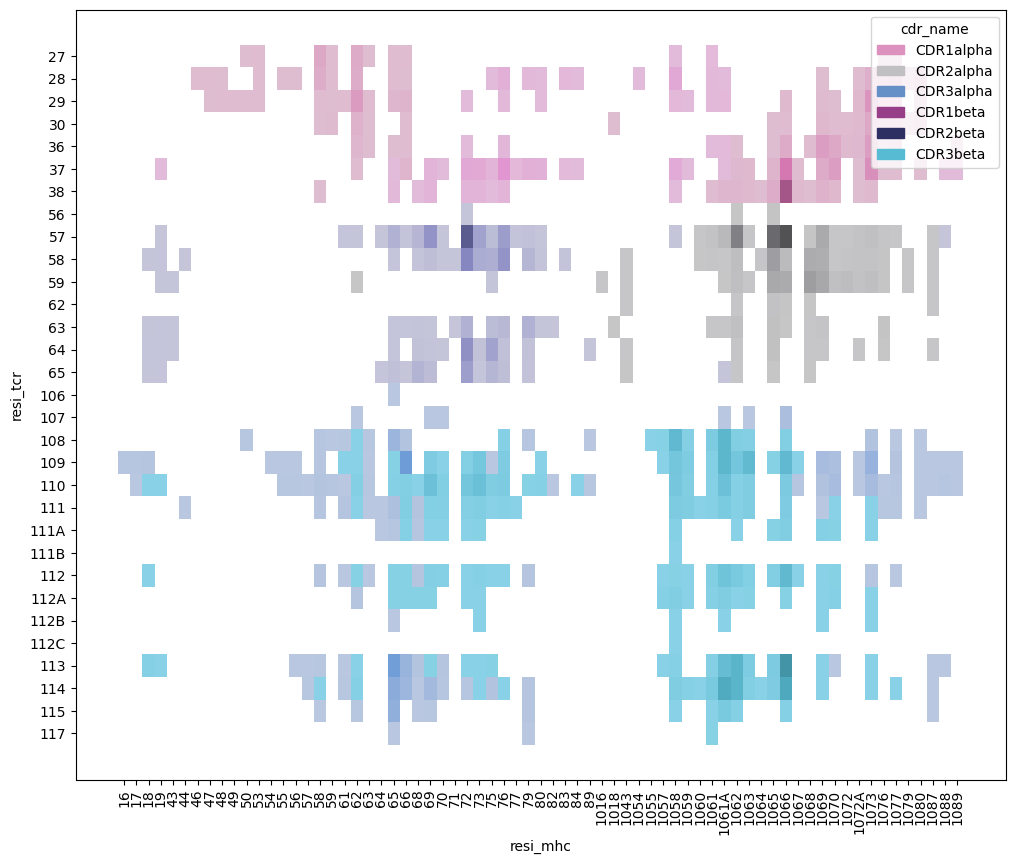

In [10]:
contacts['colour'] = contacts['cdr_name'].map({
    'CDR1alpha': 'DC91BE',
    'CDR2alpha': 'C0C0C2',
    'CDR3alpha': '6490C7',
    'CDR1beta': '963E87',
    'CDR2beta': '636363',
    'CDR3beta': '56BBD3',
}).str.lower()
palette = ['#' + colour.lower() for colour in ['DC91BE','C0C0C2', '6490C7', '963E87','2D2E62','56BBD3']]
contacts['cdr_name'] = pd.Categorical(contacts['cdr_name'], ['CDR1alpha', 'CDR2alpha', 'CDR3alpha', 'CDR1beta', 'CDR2beta', 'CDR3beta'])
plt.figure(figsize=(12, 10))

sns.histplot(contacts, x='resi_mhc', y='resi_tcr', hue='cdr_name', palette=sns.color_palette(palette, 6))
plt.xticks(rotation=90)
print()